In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

sns.set_style('whitegrid')

In [2]:
#Importamos los datos
fashion_mnist = input_data.read_data_sets("data/fashion", source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Exploramos los datos

In [3]:
fashion_mnist.train.images.shape

(55000, 784)

In [4]:
print(f"Training set images shape : {fashion_mnist.train.images.shape}")
print(f"Training set labels shape : {fashion_mnist.train.labels.shape}")

print(f"Test set images shape : {fashion_mnist.test.images.shape}")
print(f"Test set labels shape : {fashion_mnist.test.labels.shape}")

Training set images shape : (55000, 784)
Training set labels shape : (55000, 10)
Test set images shape : (10000, 784)
Test set labels shape : (10000, 10)


In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Label: Coat


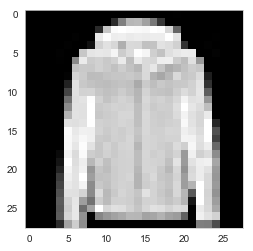

In [6]:
print(f"Label: {class_names[np.where(fashion_mnist.train.labels[0] == 1)[0][0]]}")
plt.imshow(fashion_mnist.train.images[0].reshape(28,28), cmap="gist_gray")
plt.grid(False)

# Placeholders

In [7]:
def crear_placeholders(numero_x, numero_y):
    x = tf.placeholder(tf.float32, shape=[numero_x, None])
    y = tf.placeholder(tf.float32, shape=[numero_y, None])
    
    return x, y

# Variables (Inicializamos los parametros)

In [8]:
def inicializar_parametros():
    
    # Primera capa
    w1 = tf.get_variable("w1", [128, 784], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [128, 1], initializer=tf.zeros_initializer())
    
    # Segunda capa
    w2 = tf.get_variable("w2", [128, 128], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [128, 1], initializer=tf.zeros_initializer())
    
    # Capa de salida
    w3 = tf.get_variable("w3", [10, 128], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [10, 1], initializer=tf.zeros_initializer())
    
    parametros = {
        "w1": w1,
        "b1": b1,
        "w2": w2,
        "b2": b2,
        "w3": w3,
        "b3": b3
    }
    
    return parametros  

# Operaciones (Forward propagation)

In [9]:
def forward_propagation(x, parametros):
    
    w1 = parametros['w1']
    b1 = parametros['b1']
    w2 = parametros['w2']
    b2 = parametros['b2']
    w3 = parametros['w3']
    b3 = parametros['b3']
    
    z1 = tf.add(tf.matmul(w1,x), b1)
    a1 = tf.nn.relu(z1)                  
    z2 = tf.add(tf.matmul(w2,a1), b2)    
    a2 = tf.nn.relu(z2)                  
    z3 = tf.add(tf.matmul(w3,a2), b3)
    
    return z3

In [32]:
def save_model(session, file_name): 
    saver = tf.train.Saver()
    saver.save(session, f"/tmp/{file_name}")
    print("Modelo guardado")

# Loss function

In [27]:
def compute_loss(z, y_true):
    
    logits = tf.transpose(z)
    labels = tf.transpose(y_true)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    
    return loss

# Optimizer (Backpropagation)

In [28]:
def optimize(loss, learning_rate=0.001):
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return optimizer

# Modelo

In [33]:
def modelo(train, test, learning_rate=0.001, num_epochs=16, minibatch_size=32, print_loss=True, graph_filename="loss", save_session=True):
    
    tf.reset_default_graph()
    
    (numero_x, m) = train.images.T.shape
    numero_y = train.labels.T.shape[0]
    
    losses = []
    
    x, y = crear_placeholders(numero_x, numero_y)
    
    parametros = inicializar_parametros()
    
    z3 = forward_propagation(x, parametros)
    
    loss = compute_loss(z3, y)
    
    optimizer = optimize(loss, learning_rate)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
             
                epoch_loss = 0.
                numero_minibatches = int(m / minibatch_size)
                
                for i in range(numero_minibatches):
                    
                    minibatch_x, minibatch_y = train.next_batch(minibatch_size)
                    
                    _, minibatch_loss = sess.run([optimizer, loss], feed_dict={x:minibatch_x.T, y:minibatch_y.T})
                    
                    epoch_loss += minibatch_loss / numero_minibatches
                
                if print_loss == True:
                    print(f"Perdida en epoch {epoch}: {epoch_loss}")
                    losses.append(epoch_loss)
        
        plt.figure(figsize=(16,5))
        plt.plot(np.squeeze(losses), color='#2A688B')
        plt.xlim(0, num_epochs-1)
        plt.ylabel("Perdida")
        plt.xlabel("Iteraciones")
        plt.title(f"Learning rate: {learning_rate}")
        plt.savefig(graph_filename, dpi=300)
        
        parametros = sess.run(parametros)
        print("Parametros entrenados!")
        
        correct_prediction = tf.equal(tf.argmax(z3), tf.argmax(y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))
        
        print("Train Accuracy: ", accuracy.eval({x: train.images.T, y: train.labels.T}))
        print("Test Accuracy: ", accuracy.eval({x: test.images.T, y: test.labels.T}))
        
        if save_session == True:
            save_model(sess, "fashion_mnist")
        
        return parametros

# Test del modelo

In [34]:
train = fashion_mnist.train
test = fashion_mnist.test

Perdida en epoch 0: 0.4934147385245021
Perdida en epoch 1: 0.36578468660085645
Perdida en epoch 2: 0.3309286847337649
Perdida en epoch 3: 0.3093704807488582
Perdida en epoch 4: 0.2888271213304232
Perdida en epoch 5: 0.27705449670904486
Perdida en epoch 6: 0.26614837752323456
Perdida en epoch 7: 0.2511609720003302
Perdida en epoch 8: 0.24059715384359395
Perdida en epoch 9: 0.232127299676492
Perdida en epoch 10: 0.22734811503333882
Perdida en epoch 11: 0.21657799776292228
Perdida en epoch 12: 0.20917563556397517
Perdida en epoch 13: 0.2020835925248147
Perdida en epoch 14: 0.19680298166945828
Perdida en epoch 15: 0.19130802274452893
Parametros entrenados!
Train Accuracy:  0.91614544
Test Accuracy:  0.8709
Modelo guardado


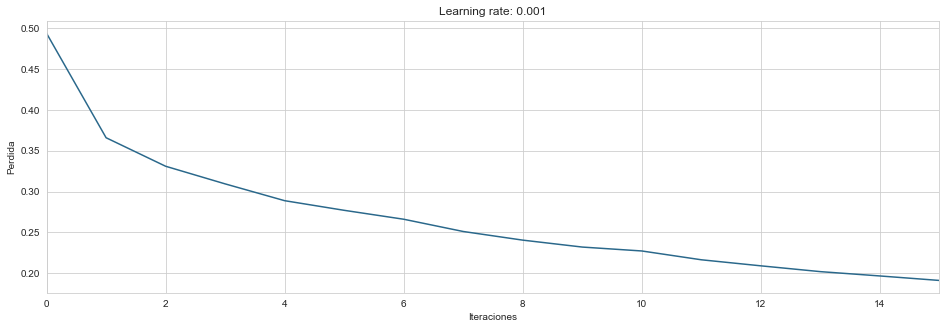

In [35]:
parameters = modelo(train, test, learning_rate=0.001)